<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/GoogleNet%20final/50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Evaluasi
import torch
import torchvision.models as models
from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 92% 148M/161M [00:01<00:00, 105MB/s]
100% 161M/161M [00:01<00:00, 89.3MB/s]


In [6]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [2]:
dataset_dir = '/content/data'

In [3]:
print(os.listdir(dataset_dir))

['Blight', 'Gray_Leaf_Spot', 'Healthy', 'Common_Rust']


In [4]:
IMAGE_SIZE_googlenet = 224

In [5]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_googlenet, IMAGE_SIZE_googlenet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [6]:
X = []
Z = []

In [7]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:06<00:00, 183.97it/s]


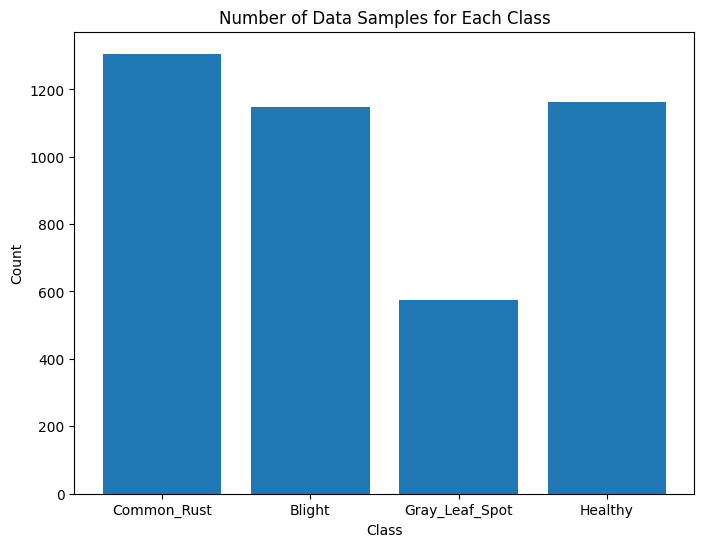

In [8]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [9]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [22]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=3)

def GoogleNet(input_shape=(227, 227, 3), num_classes=4):
    inputs = Input(input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x, name='googlenet')
    return model

# Create the GoogleNet model
model = GoogleNet(input_shape=(224, 224, 3), num_classes=4)
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, Y_train), epochs=50, validation_data=(X_test, Y_test))

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_168 (Conv2D)         (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_39 (MaxPooli  (None, 56, 56, 64)           0         ['conv2d_168[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_169 (Conv2D)         (None, 56, 56, 192)          110784    ['max_pooling2d_39[0][

27/27 [==============================] - 1s 29ms/step


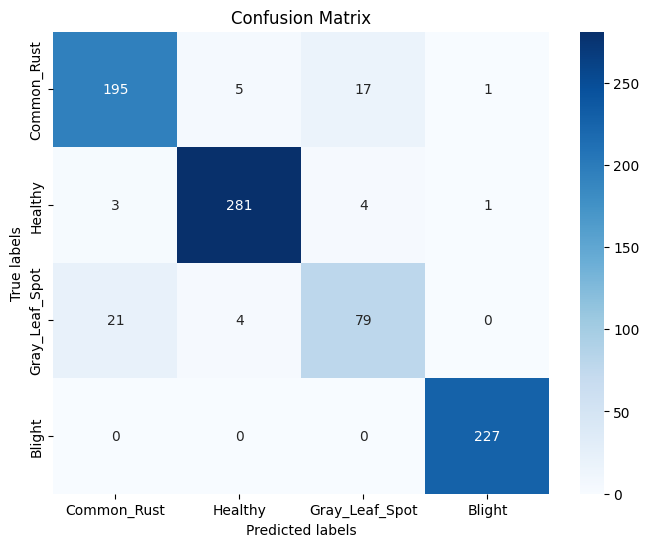


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       218
           1       0.97      0.97      0.97       289
           2       0.79      0.76      0.77       104
           3       0.99      1.00      1.00       227

    accuracy                           0.93       838
   macro avg       0.91      0.91      0.91       838
weighted avg       0.93      0.93      0.93       838



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)

In [18]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=1):
    # Create a concrete function from the model
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size] + [int(dim) for dim in model.inputs[0].shape[1:]], model.inputs[0].dtype))

    # Convert the model function to a frozen graph
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    # Calculate FLOPs
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

In [24]:
model = GoogleNet(input_shape=(224, 224, 3), num_classes=4)
model.build(input_shape=(None, 224, 224, 3))

In [25]:
flops = get_flops(model)
print(f"Estimated FLOPs: {flops}")

Estimated FLOPs: 3155495536
